## **Portfolio Assessment**

In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import make_column_transformer, ColumnTransformer, TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
import copy
import statsmodels.api as sm
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import xgboost as xgb
from hyperopt import fmin, tpe, hp, anneal, Trials
from hyperopt import space_eval
from itertools import chain
from functools import reduce

In [2]:
# Import df with volatility predictions
test = pd.read_csv("predicted_df.csv")

------------------------------------------------------------------

## **Build Portfolios**

### **Fama-French Factors**

In [3]:
# Import Fama-French Factors df
ff_factors = pd.read_csv("ff_factors.csv")
ff_factors.loc[:,["Mkt-RF", "SMB", "HML", "RF"]] = ff_factors.loc[:,["Mkt-RF", "SMB", "HML", "RF"]] / 100
ff_factors = ff_factors[(ff_factors.Date >= "2005-01") & (ff_factors.Date < "2023-01")].reset_index(drop="True")
ff_factors.rename({"Date":"datadate"}, axis=1, inplace=True)
ff_factors.datadate = ff_factors.datadate + "-01"

In [4]:
# Merge dfs
test = pd.merge(left=test, right=ff_factors[['datadate', 'RF']], on='datadate', how='left')
test.rename({'RF_y':'RF'},axis=1,inplace=True)
# Calculate excess returns
test['exc_ret'] = test['ret'] - test['RF']

### **Benchmark Portfolios**

In [5]:
# Equal Weighted Portfolio
ew_portfolio = test.groupby('datadate')['exc_ret'].mean().reset_index()
ew_portfolio.rename({"exc_ret":"EW Portfolio"}, axis=1, inplace=True)

In [6]:
# Value Weighted Portfolio
test['exc_vw_ret'] = test['weight'] * test['exc_ret']
vw_portfolio = test.groupby('datadate')['exc_vw_ret'].sum().reset_index()
vw_portfolio.rename({"exc_vw_ret":"VW Portfolio"}, axis=1, inplace=True)

### **Moreira and Muir Portfolios**

Moreira and Muir (2017) original proposal for volatility-managed portfolios.

Constant c controls the average exposure of the strategy.

For ease of interpretation, we choose c so that the managed portfolio has the same unconditional standard deviation as the VW Portfolio.

In [7]:
# Moreira and Muir

def build_moreira_muir(c, returns, rf, volatility_approx, dates, name_returns):

    # Weight for risk-asset
    w = (c/(volatility_approx**2))

    # Calculate returns based on weight
    portfolio_returns = (w * returns) + ((1-w) * rf)
    # Form df
    portfolio_returns = pd.DataFrame(data = {'datadate':dates, name_returns:portfolio_returns})
    
    return portfolio_returns, w

In [8]:
# Dates
dates = test.groupby('datadate').first().reset_index()['datadate'].values

# Predicted month volatility
pred_month_vol = test.groupby('datadate')['garch_vol'].first().reset_index()['garch_vol']
pred_mm_portfolio, w_pred_mm = build_moreira_muir(0.00218, vw_portfolio['VW Portfolio'], ff_factors['RF'], pred_month_vol, dates, 'Predicted MM Portfolio')

# Past month volatility
prev_month_vol = test.groupby('datadate')['index_volatility_1m'].first().reset_index()['index_volatility_1m']
prev_mm_portfolio, w_prev_mm = build_moreira_muir(0.001102, vw_portfolio['VW Portfolio'], ff_factors['RF'], prev_month_vol, dates, 'Previous MM Portfolio')


### **Replication Portfolios**

Levered portfolio, weights for individual assets are attained by adapting the Moreira and Muir (2017) method to the stock level, adjusting the Value-Weighted weights of the market portfolio.

In [9]:
# Replication
def mm_replication_portfolio(type, variable, c):

    # Weight inverted
    test[f"w_rep_{type}"] = c / (test[variable]**2)
    
    # Adjust Weight
    test[f"w_rep_{type}"] = test[f"w_rep_{type}"] * test['weight_1m']

    # Save weights
    weights = test.groupby('datadate')[f"w_rep_{type}"].sum()

    # Weight x Return
    test[f"ret_w_rep_{type}"] = test['exc_ret'] * test[f"w_rep_{type}"]

    portfolio = test.groupby('datadate')[f"ret_w_rep_{type}"].sum().reset_index()
    portfolio = portfolio.rename({f"ret_w_rep_{type}":f"Replication {type} Portfolio"}, axis=1)
    
    return portfolio, weights

# Predicted month volatility
rep_pred_portfolio, w_pred_rep = mm_replication_portfolio("Predicted", 'predicted_volatility', 0.00604)

# Past month volatility
rep_prev_portfolio, w_prev_rep = mm_replication_portfolio("Previous", 'vol_1m', 0.004188)

### **Inverse Portfolios**

Unlevered, 100% invested on the risky asset portfolio. Constructed based on the inversion of the variance for a given asset.

In [10]:
# Inverted
def build_inverted_weighted_portfolio(type, variable):

    # Weight unadjusted
    test[f"w_inv_{type}"] = 1 / (test[variable]**2)
    
    # Sum all weights
    sum_weights = test.groupby('datadate')[f"w_inv_{type}"].transform('sum')

    # Adjusted Weight
    test[f"w_inv_{type}"] = test[f"w_inv_{type}"] / sum_weights

    # Weight x Return
    test[f"ret_w_inv_{type}"] = test['exc_ret'] * test[f"w_inv_{type}"]

    portfolio = test.groupby('datadate')[f"ret_w_inv_{type}"].sum().reset_index()
    portfolio = portfolio.rename({f"ret_w_inv_{type}":f"Inv. {type} Portfolio"}, axis=1)
    
    return portfolio

# Predicted month volatility
inv_pred_portfolio = build_inverted_weighted_portfolio("Predicted", 'predicted_volatility')

# Past month volatility
inv_prev_portfolio = build_inverted_weighted_portfolio("Previous", 'vol_1m')

### **Compare Portfolio Weights for the Risky Asset**

In [11]:
# Function to plot portfolio weights
def plot_weights(mm_weights, rep_weights, dates, labels, colors, type):

    plt.rcParams["figure.figsize"] = (15,11)
    xticks = [datetime.strptime(dates[i], "%Y-%m-%d").strftime("%Y") for i in list(range(0, len(dates), 12))]

    plt.plot(dates, mm_weights, label=labels[0], color=colors[0], alpha=0.25)
    plt.plot(dates, rep_weights, label=labels[1], color=colors[1])

    # Add a legend and title to the plot
    plt.xticks(list(range(0, len(dates), 12)), xticks, rotation=45, ha='right')
    plt.legend(prop={'size': 15})
    plt.title(f"Weights for {type} Portfolios")

    plt.axhline(y=1, color='black', linestyle='--')

    # Add vertical lines at each year
    for date in list(range(0, len(dates), 12)):
        plt.axvline(date, color='black', linestyle='--', alpha=0.1)

    # Show the plot
    plt.show()

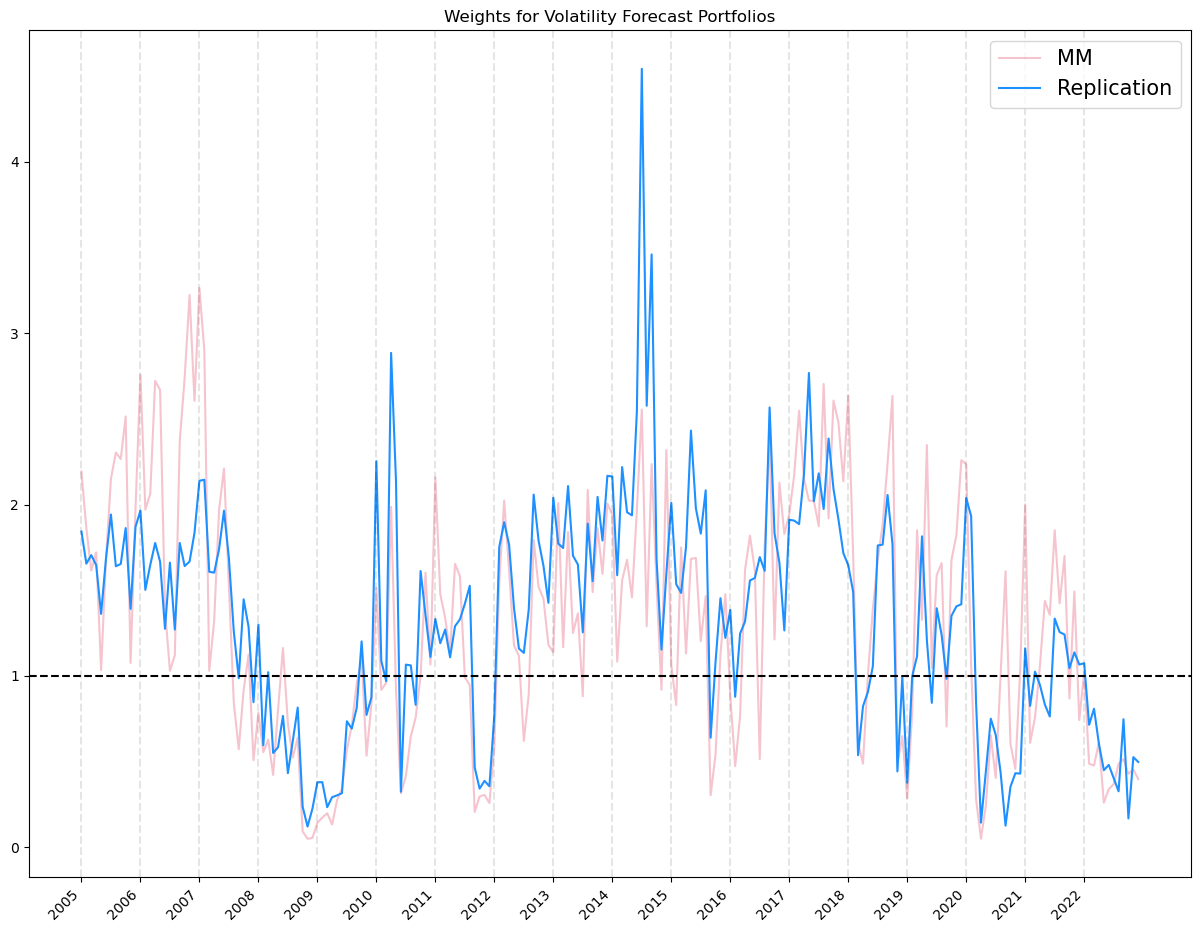

In [12]:
plot_weights(w_pred_mm, w_pred_rep, w_pred_rep.index, ["MM", "Replication"], ['crimson', 'dodgerblue'], "Volatility Forecast")

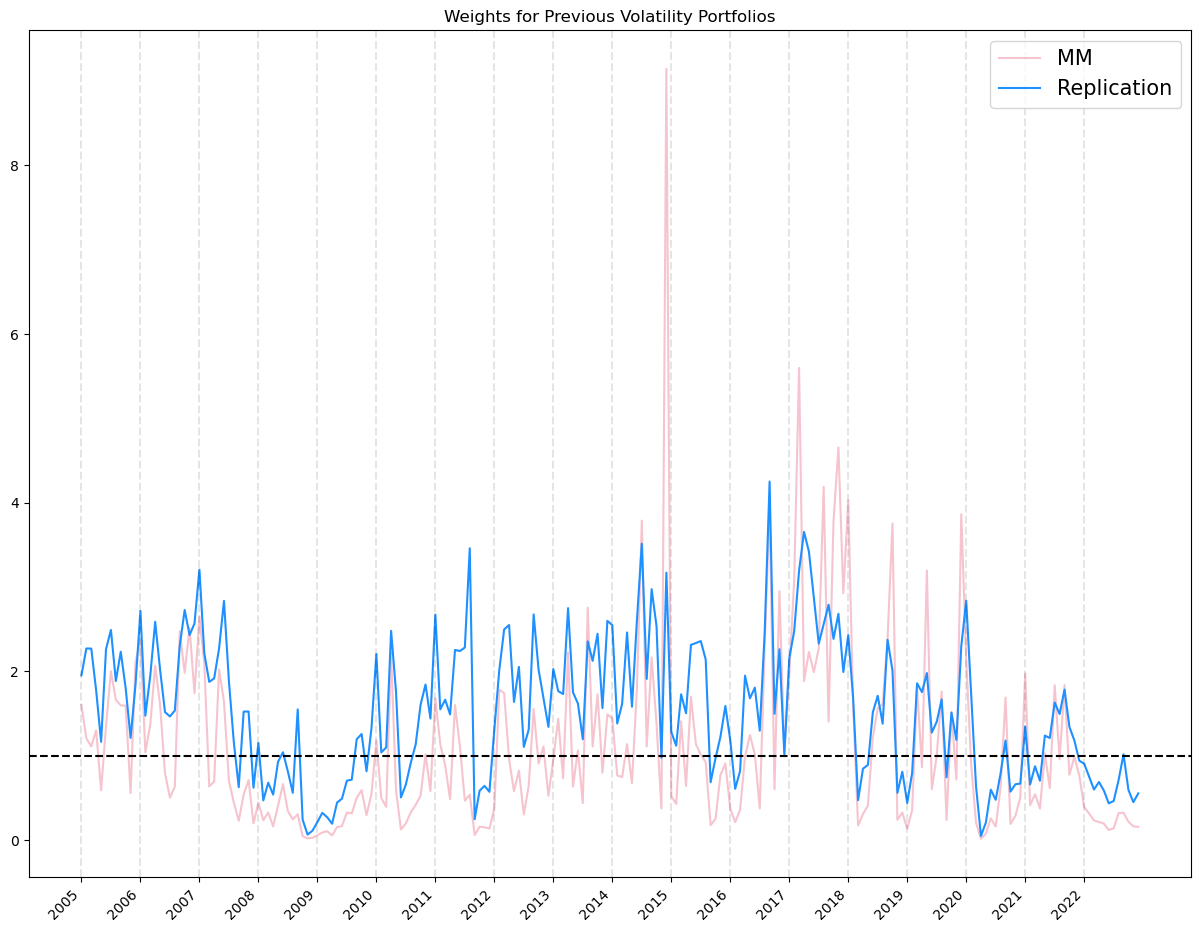

In [13]:
plot_weights(w_prev_mm, w_prev_rep, w_prev_rep.index, ["MM", "Replication"], ['crimson', 'dodgerblue'], "Previous Volatility")

## **Portfolio Statistics**

In [14]:
# Join all dfs in one
dfs = [ew_portfolio, vw_portfolio, pred_mm_portfolio, prev_mm_portfolio, rep_pred_portfolio, rep_prev_portfolio, inv_pred_portfolio, inv_prev_portfolio]
merged_df = reduce(lambda left, right: pd.merge(left, right, on='datadate', how='outer'), dfs)
merged_df.set_index('datadate', inplace=True)

In [15]:
# Calculate statistics for each portfolio
def calculate_statistics(data):

    statistics = pd.DataFrame()

    statistics['Average Monthly Return'] = data.mean()
    statistics['Monthly Returns Volatility'] = data.std()
    statistics['Annualized Return'] = data.mean() * 12
    statistics['Annualized Volatility'] = data.std() * np.sqrt(12)

    # Sharpe Ratio
    statistics['Sharpe Ratio'] = (statistics['Annualized Return']) / statistics['Annualized Volatility']
    # Downside Deviation
    statistics['Downside Deviation'] = data[data < 0].std() * np.sqrt(12)
    # Sortino Ratio
    statistics['Sortino Ratio'] = (statistics['Annualized Return']) / statistics['Downside Deviation']

    return statistics

statistics = calculate_statistics(merged_df)
statistics

,Average Monthly Return,Monthly Returns Volatility,Annualized Return,Annualized Volatility,Sharpe Ratio,Downside Deviation,Sortino Ratio
EW Portfolio,0.010895,0.046939,0.130738,0.162601,0.804044,0.121729,1.074010
VW Portfolio,0.010629,0.042755,0.127552,0.148107,0.861216,0.102326,1.246529
Predicted MM Portfolio,0.011523,0.042758,0.138280,0.148118,0.933580,0.110666,1.249529
Previous MM Portfolio,0.009592,0.042757,0.115105,0.148114,0.777135,0.137238,0.838725
Replication Predicted Portfolio,0.010855,0.042758,0.130261,0.148119,0.879435,0.112279,1.160157
Replication Previous Portfolio,0.012540,0.042757,0.150484,0.148114,1.015999,0.098728,1.524229
Inv. Predicted Portfolio,0.009559,0.041117,0.114712,0.142432,0.805382,0.107216,1.069912
Inv. Previous Portfolio,0.009336,0.034690,0.112028,0.120169,0.932249,0.088866,1.260641


## **Cumulative Returns Plots**

In [16]:
# Function to target same volatility for all portfolios
def equal_volatility_dfs(dfs_list, names_list, df_statistics, target=0.1):

    ev_dfs_list = []

    for i in range(0,len(dfs_list)):

        copy_df = copy.deepcopy(dfs_list[i])
        copy_df.iloc[:,1] = copy_df.iloc[:,1] * (target / df_statistics.loc[names_list[i],'Annualized Volatility'])
        ev_dfs_list.append(copy_df)
    
    return ev_dfs_list

names_list = ['EW Portfolio', 'VW Portfolio', 'Predicted MM Portfolio', 'Previous MM Portfolio',
              'Replication Predicted Portfolio', 'Replication Previous Portfolio',
              'Inv. Predicted Portfolio', 'Inv. Previous Portfolio']

# Get equal-volatility portfolios
ev_dfs = equal_volatility_dfs(dfs, names_list, statistics)
ev_dfs = reduce(lambda left, right: pd.merge(left, right, on='datadate'), ev_dfs)
ev_dfs = ev_dfs.set_index("datadate")

In [17]:
# Check if equal volatility is working properly
calculate_statistics(ev_dfs)

,Average Monthly Return,Monthly Returns Volatility,Annualized Return,Annualized Volatility,Sharpe Ratio,Downside Deviation,Sortino Ratio
EW Portfolio,0.006700,0.028868,0.080404,0.1,0.804044,0.074864,1.074010
VW Portfolio,0.007177,0.028868,0.086122,0.1,0.861216,0.069089,1.246529
Predicted MM Portfolio,0.007780,0.028868,0.093358,0.1,0.933580,0.074715,1.249529
Previous MM Portfolio,0.006476,0.028868,0.077713,0.1,0.777135,0.092657,0.838725
Replication Predicted Portfolio,0.007329,0.028868,0.087943,0.1,0.879435,0.075803,1.160157
Replication Previous Portfolio,0.008467,0.028868,0.101600,0.1,1.015999,0.066657,1.524229
Inv. Predicted Portfolio,0.006712,0.028868,0.080538,0.1,0.805382,0.075276,1.069912
Inv. Previous Portfolio,0.007769,0.028868,0.093225,0.1,0.932249,0.073950,1.260641


In [18]:
cumulative_returns = (1 + ev_dfs[ev_dfs.columns]).cumprod() - 1

def plot_cumulative_rets(portfolio_list, cumulative_returns=cumulative_returns):

    # Convert 'datadate' index to datetime format
    cumulative_returns.index = pd.to_datetime(cumulative_returns.index)
    cumulative_returns[portfolio_list].plot()

    # Get the current Axes instance
    ax = plt.gca()

    # Set xticks at regular intervals
    date_ticks = cumulative_returns.index
    date_ticks_freq = int(len(date_ticks) / 17)
    ax.set_xticks(date_ticks[::date_ticks_freq])
    ax.set_xticklabels(date_ticks[::date_ticks_freq].strftime('%Y'))

    # Add vertical lines at each year
    for year in date_ticks[::date_ticks_freq].year:
        plt.axvline(pd.Timestamp(f"{year}-01-01"), color='black', linestyle='--', alpha=0.1)

    # Display the plot
    plt.show()

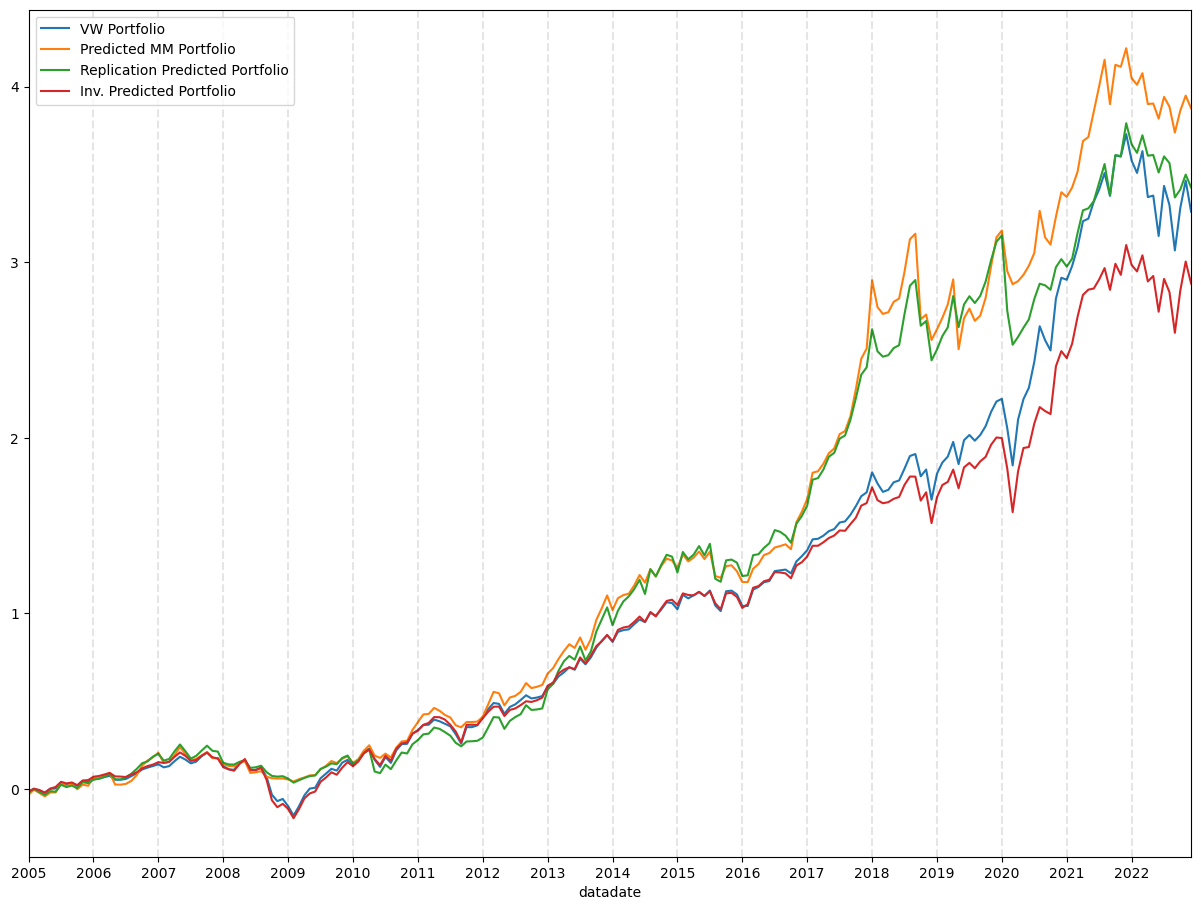

In [19]:
plot_cumulative_rets(['VW Portfolio', 'Predicted MM Portfolio', 'Replication Predicted Portfolio', 'Inv. Predicted Portfolio'])

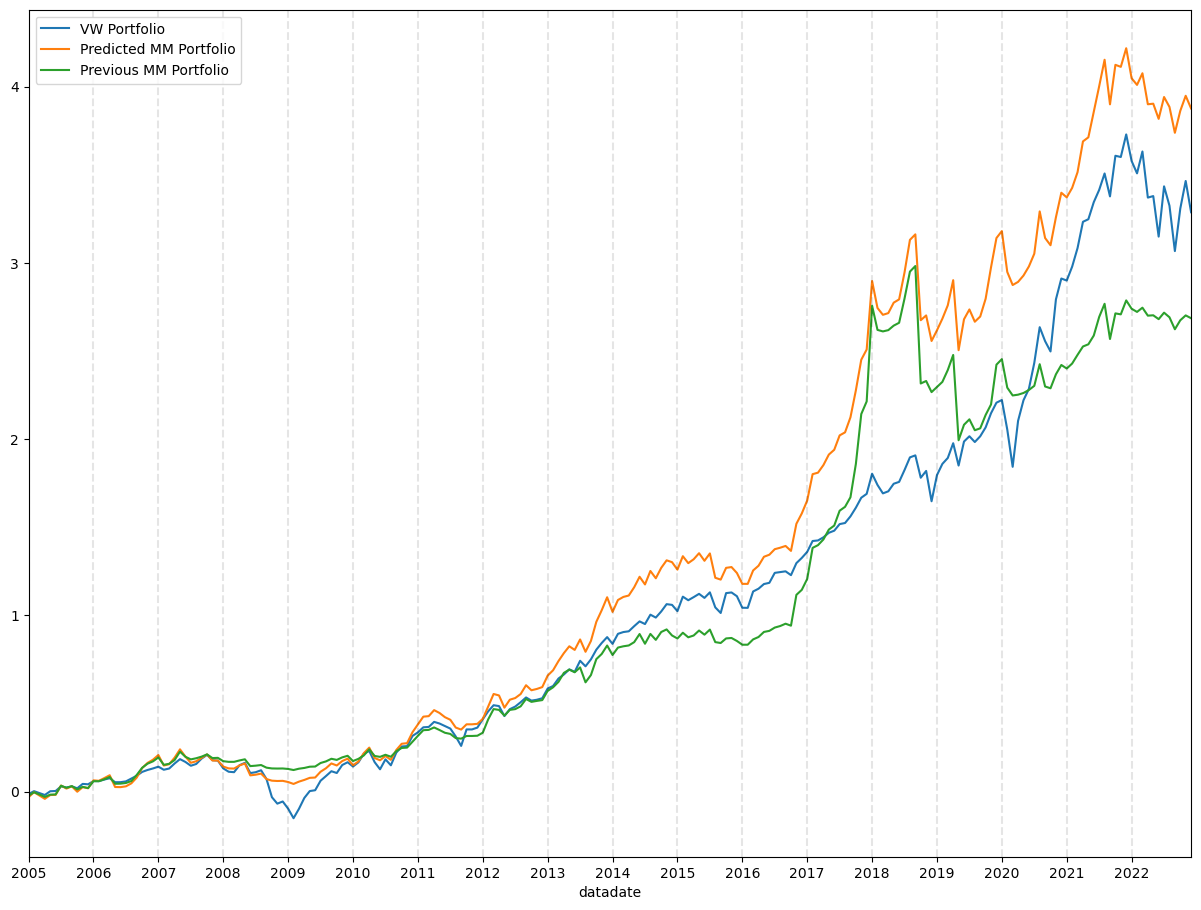

In [20]:
plot_cumulative_rets(['VW Portfolio', 'Predicted MM Portfolio', 'Previous MM Portfolio'])

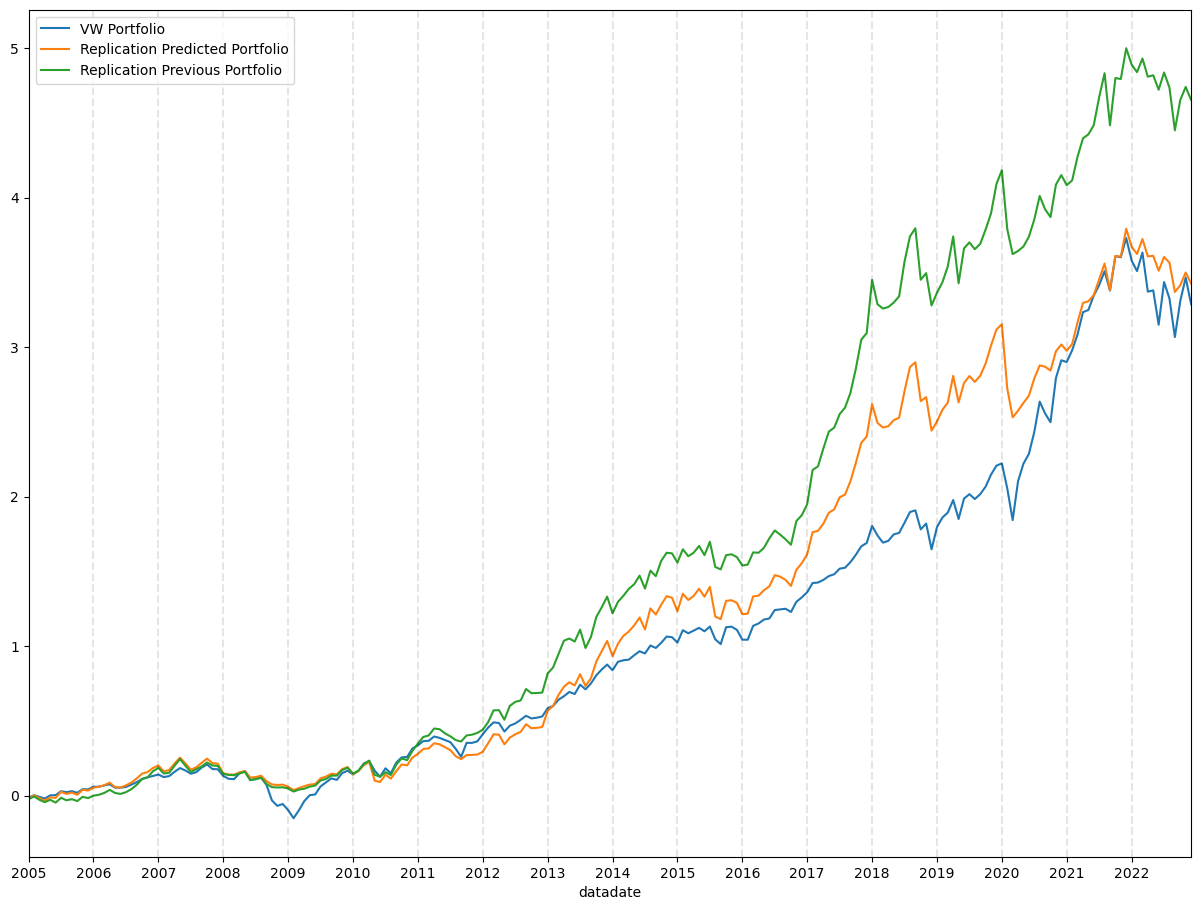

In [21]:
plot_cumulative_rets(['VW Portfolio', 'Replication Predicted Portfolio', 'Replication Previous Portfolio'])

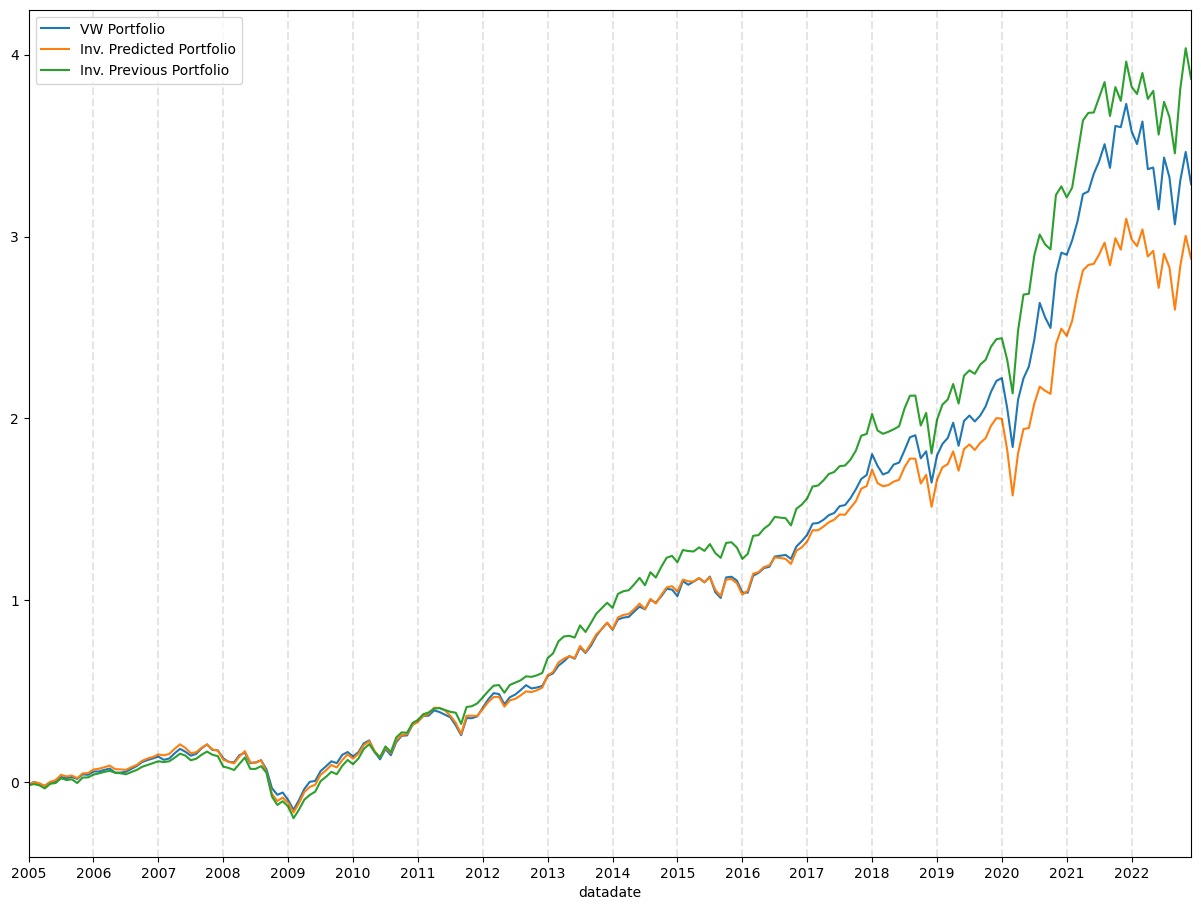

In [22]:
plot_cumulative_rets(['VW Portfolio', 'Inv. Predicted Portfolio', 'Inv. Previous Portfolio'])

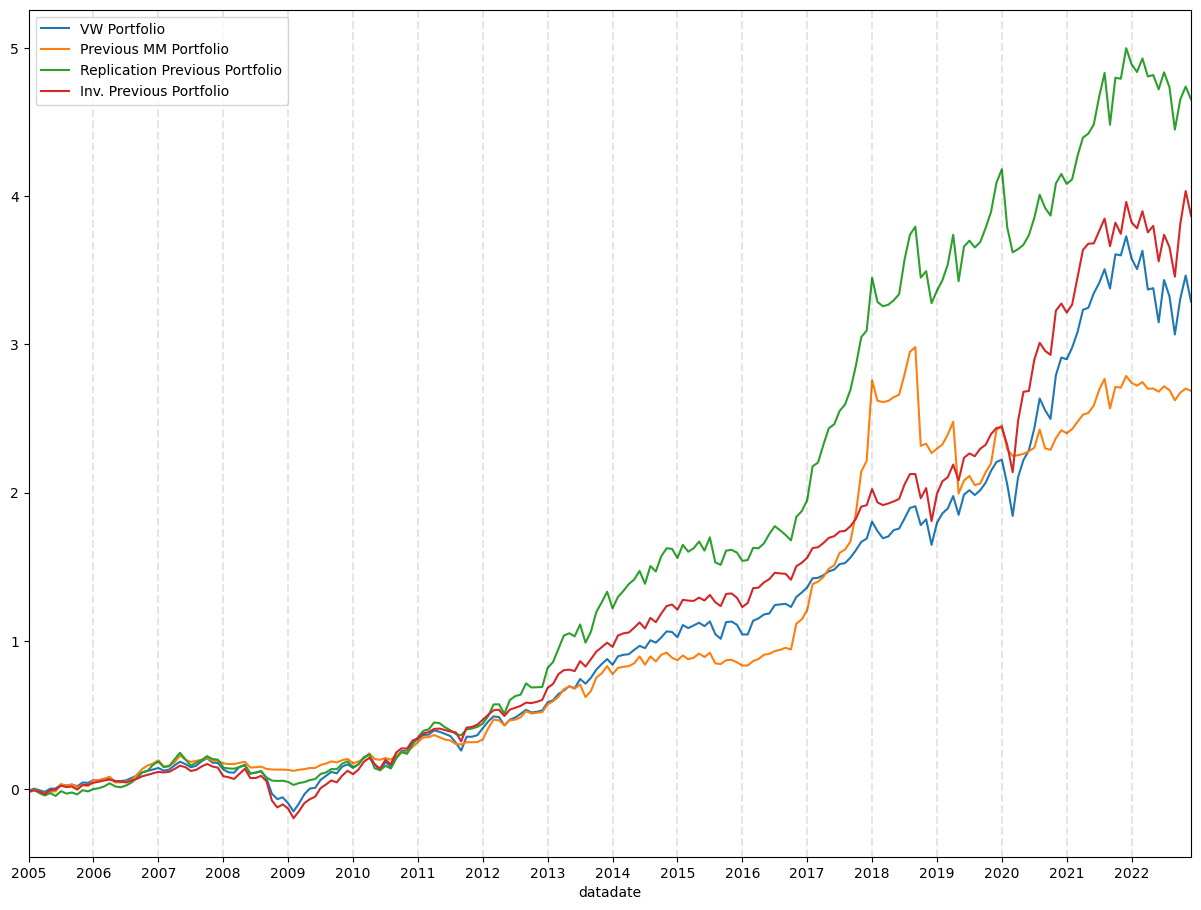

In [23]:
plot_cumulative_rets(['VW Portfolio', 'Previous MM Portfolio', 'Replication Previous Portfolio', 'Inv. Previous Portfolio'])

## **Factor Benchmarking**

In [24]:
new_factors = copy.deepcopy(ff_factors)
# Set market factors as our index excess returns (similar to one another)
new_factors['Mkt-RF'] = vw_portfolio['VW Portfolio']
dfs = [pred_mm_portfolio, prev_mm_portfolio, rep_pred_portfolio, rep_prev_portfolio, inv_pred_portfolio, inv_prev_portfolio]

In [25]:
# Function to format and handle small numbers
def format_number(num):
    if abs(num) < 1e-4:
        return "0.00000"
    else:
        return round(num, 5)
    
# Regress portfolio on market factor
def regress_mkt(portfolio_df, factors_df):

    endog = portfolio_df.iloc[:, 1]
    exog = sm.add_constant(factors_df.iloc[:, 1])
    reg = sm.OLS(endog, exog).fit()

    # Get alpha and tracking error
    alpha = 12 * reg.params['const']
    stdev_resid = reg.resid.std() * np.sqrt(12)

    # Get information ratio
    information_ratio = alpha / stdev_resid

    # Store results in the dictionary
    results_dict = {
        'R-squared': reg.rsquared,
        'Information Ratio': information_ratio,
        'Parameters': dict(zip(reg.params.index, reg.params)),
        'P-values': dict(zip(reg.pvalues.index, reg.pvalues))
    }

    return results_dict

# Function to display market regression results
def market_regression_results(df_list, factors_df):

    regressions_df = pd.DataFrame(data={('Index',''):[], ('R-Squared',''):[],
                                    ('Alpha', 'Coef'):[], ('Alpha', 'P-Value'):[],
                                    ('Mkt-RF', 'Coef'):[], ('Mkt-RF', 'P-Value'):[], 
                                    ('Information Ratio', ''):[]})

    for portfolio in df_list:

        results = regress_mkt(portfolio, factors_df)
        parameters = results['Parameters']
        pvalues = results['P-values']
        regressions_df.loc[len(regressions_df.index)] = [portfolio.columns[1], results['R-squared'],
                                                        parameters['const'], pvalues['const'],
                                                        parameters['Mkt-RF'], pvalues['Mkt-RF'],
                                                        results['Information Ratio']]
        
    regressions_df.set_index("Index", inplace=True)
    regressions_df = regressions_df.apply(lambda x: x.map(format_number)).astype(str)

    return regressions_df

market_regression_results(dfs, new_factors)

R-Squared    Alpha            Mkt-RF           \
                                              Coef  P-Value     Coef  P-Value   
Index                                                                           
Predicted MM Portfolio             0.5718  0.00349  0.07779  0.75623  0.00000   
Previous MM Portfolio             0.32065  0.00357  0.15065  0.56629  0.00000   
Replication Predicted Portfolio   0.63378  0.00239  0.18978  0.79617  0.00000   
Replication Previous Portfolio    0.59178  0.00436  0.02406  0.76931  0.00000   
Inv. Predicted Portfolio          0.94936  -0.0004  0.53865  0.93702  0.00000   
Inv. Previous Portfolio           0.90156  0.00115  0.13532   0.7704  0.00000   

                                Information Ratio  
                                                   
Index                                              
Predicted MM Portfolio                    0.43148  
Previous MM Portfolio                      0.3512  
Replication Predicted Portfolio           0.32027  
Replication Previous Portfolio            0.55326  
Inv. Predicted Portfolio                 -0.14994  
Inv. Previous Portfolio                     0.365

In [26]:
# Regress portfolio on all factors
def regress_all(portfolio_df, factors_df):

    endog = portfolio_df.iloc[:, 1]
    exog = sm.add_constant(factors_df.iloc[:, [1, 2, 3]])
    reg = sm.OLS(endog, exog).fit()

    # Get alpha and tracking error
    alpha = 12 * reg.params['const']
    stdev_resid = reg.resid.std() * np.sqrt(12)

    # Get information ratio
    information_ratio = alpha / stdev_resid

    # Store results in the dictionary
    results_dict = {
        'R-squared': reg.rsquared,
        'Information Ratio': information_ratio,
        'Parameters': dict(zip(reg.params.index, reg.params)),
        'P-values': dict(zip(reg.pvalues.index, reg.pvalues))
    }

    return results_dict

# Function to display regression results
def factor_regression_results(df_list, factors_df):

    regressions_df = pd.DataFrame(data={('Index',''):[], ('R-Squared',''):[],
                                    ('Alpha', 'Coef'):[], ('Alpha', 'P-Value'):[],
                                    ('Mkt-RF', 'Coef'):[], ('Mkt-RF', 'P-Value'):[], 
                                    ('SMB', 'Coef'):[], ('SMB', 'P-Value'):[],
                                    ('HML', 'Coef'):[], ('HML', 'P-Value'):[],
                                    ('Information Ratio', ''):[]})

    for portfolio in df_list:

        results = regress_all(portfolio, factors_df)
        parameters = results['Parameters']
        pvalues = results['P-values']
        regressions_df.loc[len(regressions_df.index)] = [portfolio.columns[1], results['R-squared'],
                                                        parameters['const'], pvalues['const'],
                                                        parameters['Mkt-RF'], pvalues['Mkt-RF'],
                                                        parameters['SMB'], pvalues['SMB'],
                                                        parameters['HML'], pvalues['HML'],
                                                        results['Information Ratio']]
        
    regressions_df.set_index("Index", inplace=True)
    regressions_df = regressions_df.apply(lambda x: x.map(format_number)).astype(str)

    return regressions_df


factor_regression_results(dfs, new_factors)

R-Squared     Alpha            Mkt-RF  \
                                               Coef  P-Value     Coef   
Index                                                                   
Predicted MM Portfolio            0.58132   0.00326  0.09798  0.77501   
Previous MM Portfolio             0.32508   0.00338  0.17605  0.58407   
Replication Predicted Portfolio   0.64431   0.00207  0.25319  0.82918   
Replication Previous Portfolio    0.61002   0.00393  0.03871  0.81277   
Inv. Predicted Portfolio          0.95562  -0.00016   0.7954   0.9141   
Inv. Previous Portfolio           0.90408   0.00127  0.09545  0.75848   

                                               SMB                HML  \
                                 P-Value      Coef  P-Value      Coef   
Index                                                                   
Predicted MM Portfolio           0.00000  -0.02609  0.75105  -0.13071   
Previous MM Portfolio            0.00000  -0.05712  0.58434  -0.07905   
Replication Predicted Portfolio  0.00000  -0.17018  0.02558  -0.05816   
Replication Previous Portfolio   0.00000  -0.21733  0.00663  -0.08589   
Inv. Predicted Portfolio         0.00000   0.09211  0.00042   0.07636   
Inv. Previous Portfolio          0.00000   0.04515  0.15828   0.04349   

                                         Information Ratio  
                                 P-Value                    
Index                                                       
Predicted MM Portfolio           0.03171           0.40767  
Previous MM Portfolio            0.30418           0.33298  
Replication Predicted Portfolio  0.29772           0.28103  
Replication Previous Portfolio   0.14242           0.51023  
Inv. Predicted Portfolio         0.00000          -0.06368  
Inv. Previous Portfolio          0.06534           0.41079

#### **BAB Exposure**

In [27]:
# Import BAB factor data
bab_factor = pd.read_csv('bab_factor.csv')
bab_factor = bab_factor[(bab_factor.datadate >= "2005-01") & (bab_factor.datadate < "2023-01")].reset_index(drop="True")
bab_factor.datadate = bab_factor.datadate + "-01"

In [28]:
# Regress portfolio on FF3 + BAB
def regress_bab(portfolio_df, factors_df):

    endog = portfolio_df.iloc[:, 1]
    exog = sm.add_constant(factors_df.iloc[:, [1, 2, 3, 5]])
    reg = sm.OLS(endog, exog).fit()

    # Get alpha and tracking error
    alpha = 12 * reg.params['const']
    stdev_resid = reg.resid.std() * np.sqrt(12)

    # Get information ratio
    information_ratio = alpha / stdev_resid

    # Store results in the dictionary
    results_dict = {
        'R-squared': reg.rsquared,
        'Information Ratio': information_ratio,
        'Parameters': dict(zip(reg.params.index, reg.params)),
        'P-values': dict(zip(reg.pvalues.index, reg.pvalues))
    }

    return results_dict

# Function to display regression results
def bab_regression_results(df_list, factors_df):

    regressions_df = pd.DataFrame(data={('Index',''):[], ('R-Squared',''):[],
                                    ('Alpha', 'Coef'):[], ('Alpha', 'P-Value'):[],
                                    ('Mkt-RF', 'Coef'):[], ('Mkt-RF', 'P-Value'):[],
                                    ('SMB', 'Coef'):[], ('SMB', 'P-Value'):[],
                                    ('HML', 'Coef'):[], ('HML', 'P-Value'):[],
                                    ('BAB', 'Coef'):[], ('BAB', 'P-Value'):[],
                                    ('Information Ratio', ''):[]})

    for portfolio in df_list:

        results = regress_bab(portfolio, factors_df)
        parameters = results['Parameters']
        pvalues = results['P-values']
        regressions_df.loc[len(regressions_df.index)] = [portfolio.columns[1], results['R-squared'],
                                                        parameters['const'], pvalues['const'],
                                                        parameters['Mkt-RF'], pvalues['Mkt-RF'],
                                                        parameters['SMB'], pvalues['SMB'],
                                                        parameters['HML'], pvalues['HML'],
                                                        parameters['BAB'], pvalues['BAB'],
                                                        results['Information Ratio']]
        
    regressions_df.set_index("Index", inplace=True)
    regressions_df = regressions_df.apply(lambda x: x.map(format_number)).astype(str)

    return regressions_df

In [29]:
all_factors = new_factors.copy()
all_factors['BAB'] = bab_factor.BAB
bab_regression_results(dfs, all_factors)

R-Squared     Alpha            Mkt-RF  \
                                               Coef  P-Value     Coef   
Index                                                                   
Predicted MM Portfolio            0.58157   0.00315  0.11454  0.77466   
Previous MM Portfolio             0.32515   0.00332  0.18985  0.58388   
Replication Predicted Portfolio   0.65401    0.0014  0.44068  0.82699   
Replication Previous Portfolio    0.62029   0.00324  0.08835  0.81052   
Inv. Predicted Portfolio          0.95907  -0.00055  0.36242  0.91284   
Inv. Previous Portfolio           0.90569   0.00105  0.17082  0.75776   

                                               SMB                HML  \
                                 P-Value      Coef  P-Value      Coef   
Index                                                                   
Predicted MM Portfolio           0.00000  -0.02412  0.77024  -0.12706   
Previous MM Portfolio            0.00000  -0.05606  0.59306  -0.07708   
Replication Predicted Portfolio  0.00000  -0.15791  0.03643  -0.03542   
Replication Previous Portfolio   0.00000   -0.2047  0.00983  -0.06249   
Inv. Predicted Portfolio         0.00000   0.09914  0.00000    0.0894   
Inv. Previous Portfolio          0.00000   0.04921   0.1229     0.051   

                                              BAB          Information Ratio  
                                 P-Value     Coef  P-Value                    
Index                                                                         
Predicted MM Portfolio           0.03985  0.02497  0.72334           0.39427  
Previous MM Portfolio            0.32435  0.01351   0.8801           0.32724  
Replication Predicted Portfolio  0.52676  0.15578  0.01586            0.1922  
Replication Previous Portfolio   0.28686   0.1603  0.01779           0.42597  
Inv. Predicted Portfolio         0.00000  0.08932  0.00000          -0.22709  
Inv. Previous Portfolio          0.03228  0.05148  0.05915           0.34192

## **Alpha Persistance**

In [30]:
# Function to calculate rolling alphas and betas
def robust_exposure(df, factor, rolling_months=60):
    
    alpha_ot = []
    beta_ot = []
    dates = []
    
    for month in range(0, len(df)-rolling_months, 1):
    
        subset_df = df[month: month+rolling_months]
        subset_factor = new_factors[month: month+rolling_months]
    
        endog = subset_df.iloc[:,1]
        exog = sm.add_constant(subset_factor[factor])
        reg = sm.OLS(endog, exog).fit()
    
        alpha_ot.append(reg.params['const'])
        beta_ot.append(reg.params[factor])
        dates.append(subset_df['datadate'].iloc[0])
    
    return alpha_ot, beta_ot, dates

In [31]:
# Function to plot rolling alphas
def plot_alpha_robust(alpha, dates, label, col, rolling_months=60):

    plt.rcParams["figure.figsize"] = (15,11)
    xticks = [(datetime.strptime(dates[i], "%Y-%m-%d").strftime("%Y-%m"), (datetime.strptime(dates[i], "%Y-%m-%d") + relativedelta(months=rolling_months)).strftime("%Y-%m")) for i in list(range(0, len(dates), 12))]
    plt.plot(dates, alpha, label=label, color=col)
    plt.axhline(y = 0, color = 'black', linestyle = '--')

    # Add a legend and title to the plot
    plt.xticks(list(range(0, len(dates), 12)), [str(tick) for tick in xticks], rotation=45, ha='right')
    plt.legend(prop={'size': 15})
    plt.title(f"Alpha Robustness for {label} factor")

    # Add vertical lines at each year
    for date in list(range(0, len(dates), 12)):
        plt.axvline(date, color='black', linestyle='--', alpha=0.1)

    # Show the plot
    plt.show()

# Function to plot rolling betas
def plot_beta_robust(beta, dates, label, col, rolling_months=60):

    plt.rcParams["figure.figsize"] = (15,11)
    xticks = [(datetime.strptime(dates[i], "%Y-%m-%d").strftime("%Y-%m"), (datetime.strptime(dates[i], "%Y-%m-%d") + relativedelta(months=rolling_months)).strftime("%Y-%m")) for i in list(range(0, len(dates), 12))]
    plt.plot(dates, beta, label=label, color=col)
    plt.axhline(y = 1, color = 'black', linestyle = '--')

    # Add a legend and title to the plot
    plt.xticks(list(range(0, len(dates), 12)), [str(tick) for tick in xticks], rotation=45, ha='right')
    plt.legend(prop={'size': 15})
    plt.title(f"Beta Robustness for {label} factor")

    # Add vertical lines at each year
    for date in list(range(0, len(dates), 12)):
        plt.axvline(date, color='black', linestyle='--', alpha=0.1)

    # Show the plot
    plt.show()

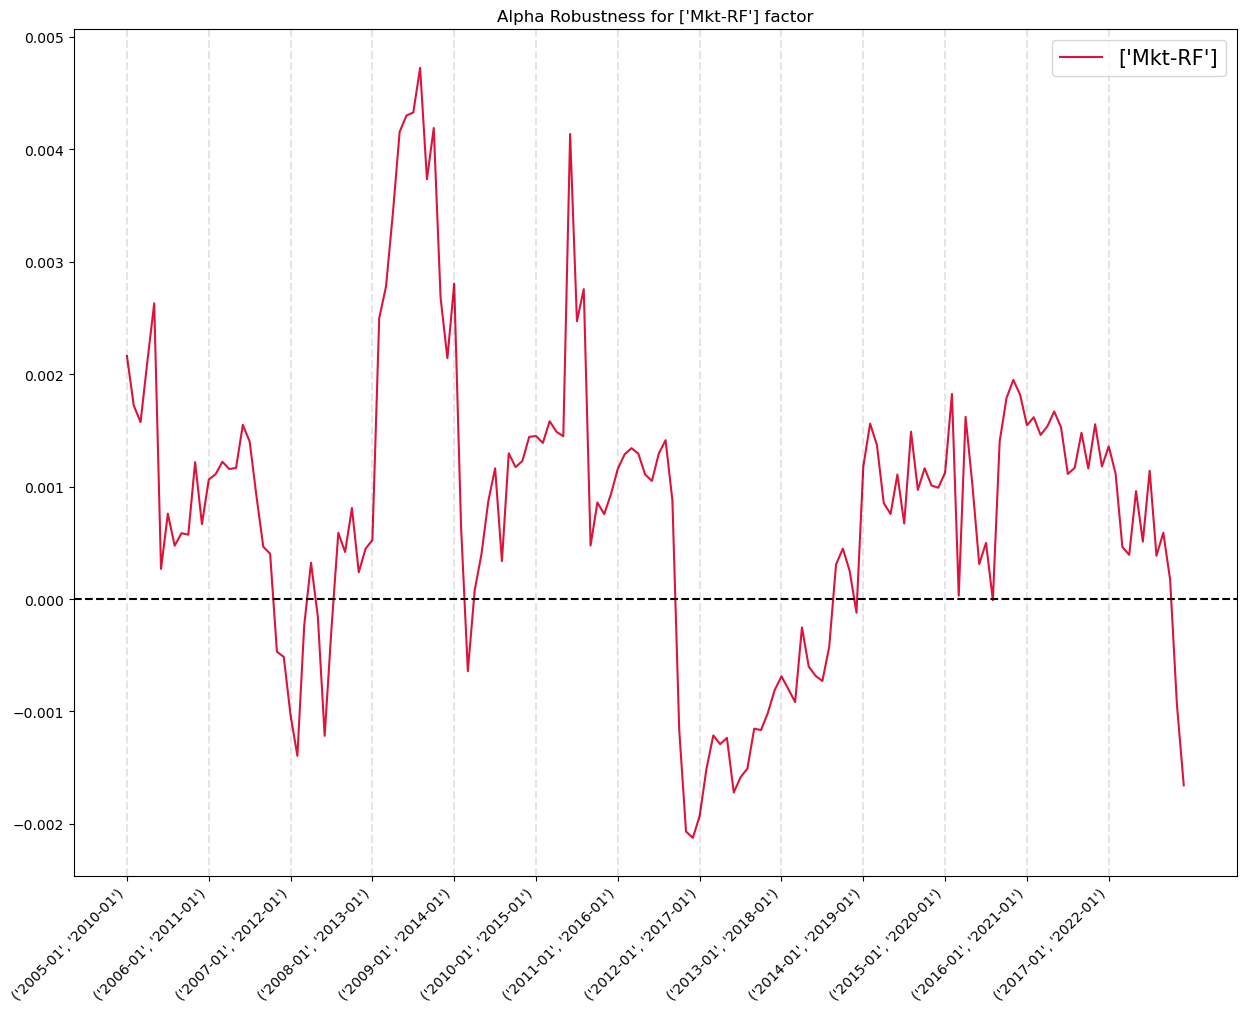

In [32]:
# Rolling Alpha of Replication Predicted Portfolio
alphas, betas, dates = robust_exposure(rep_pred_portfolio, 'Mkt-RF')
plot_alpha_robust(alphas, dates, ['Mkt-RF'], 'crimson')

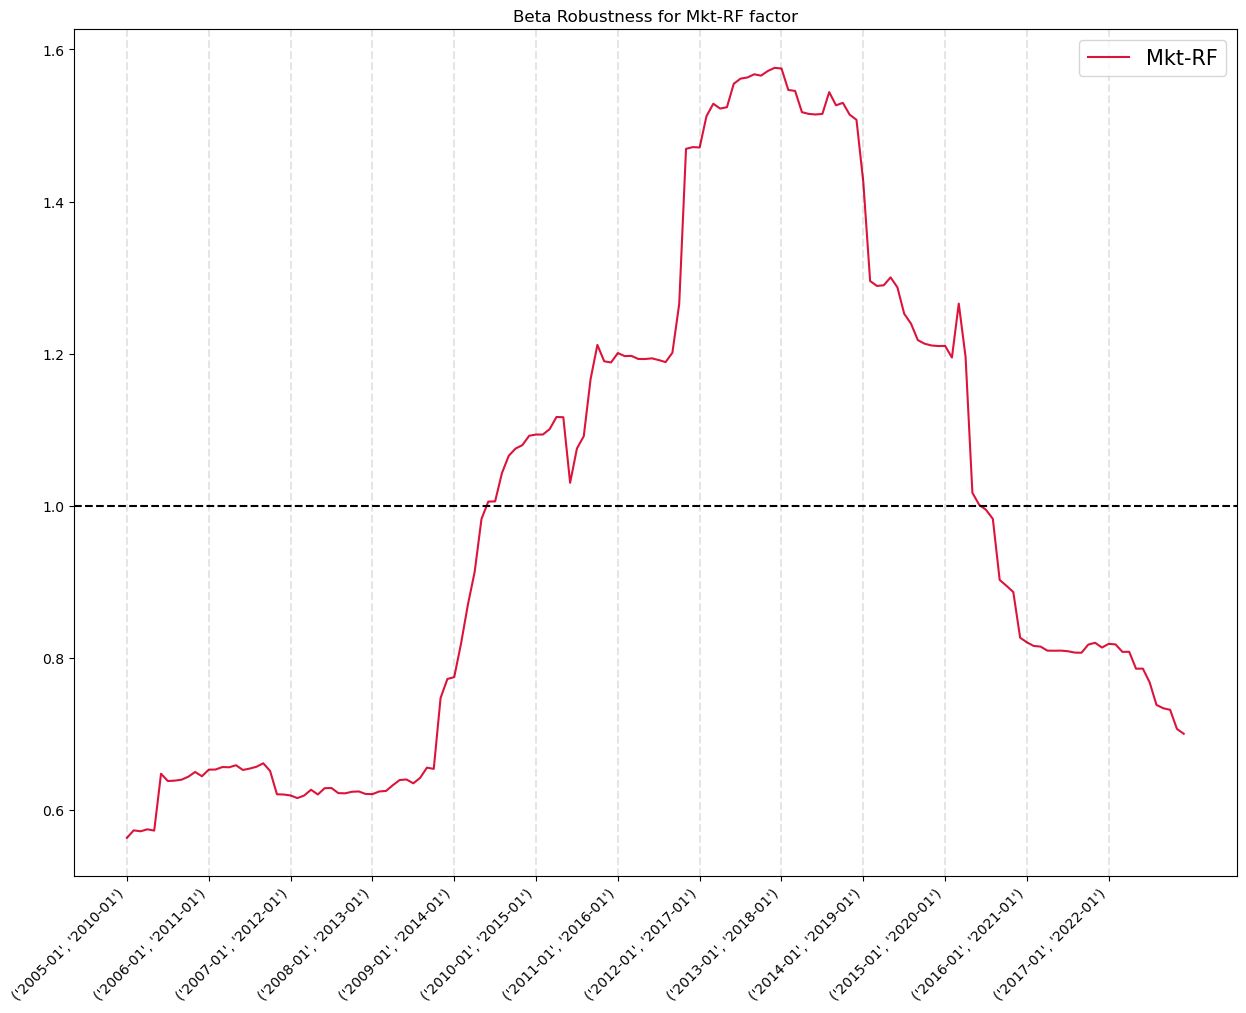

In [33]:
# Rolling Beta of Replication Predicted Portfolio
plot_beta_robust(betas, dates, 'Mkt-RF', 'crimson')

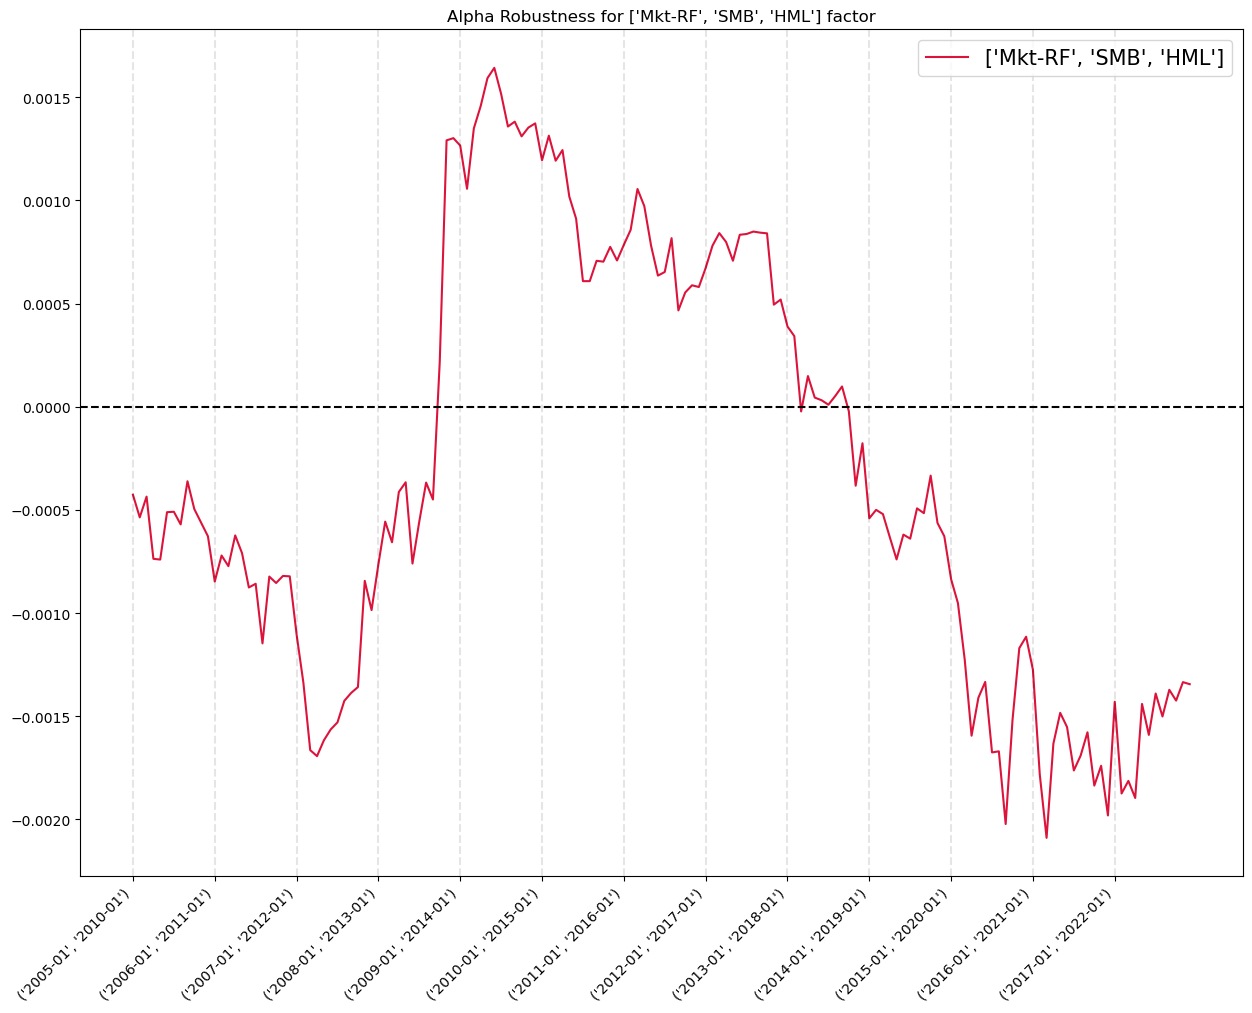

In [34]:
# Rolling Alpha of Inverse Predicted Portfolio
alphas, betas, dates = robust_exposure(inv_pred_portfolio, ['Mkt-RF', 'SMB', 'HML'])
plot_alpha_robust(alphas, dates, ['Mkt-RF', 'SMB', 'HML'], 'crimson')

In [35]:
# Function to plot multiple alpha rolling exposures
def plot_mult_alpha_robust(alpha_list, dates, labels, colors, type, rolling_months=60):
    
    plt.rcParams["figure.figsize"] = (15, 11)
    xticks = [(datetime.strptime(dates[i], "%Y-%m-%d").strftime("%Y-%m"), (datetime.strptime(dates[i], "%Y-%m-%d") + relativedelta(months=rolling_months)).strftime("%Y-%m")) for i in list(range(0, len(dates), 12))]
    
    for alpha, label, col in zip(alpha_list, labels, colors):
        plt.plot(dates, alpha, label=label, color=col)

    plt.axhline(y=0, color='black', linestyle='--')

    # Add a legend and title to the plot
    plt.xticks(list(range(0, len(dates), 12)), [str(tick) for tick in xticks], rotation=45, ha='right')
    plt.legend(prop={'size': 15})
    plt.title(f"Alpha Robustness for {type}")

    # Add vertical lines at each year
    for date in list(range(0, len(dates), 12)):
        plt.axvline(date, color='black', linestyle='--', alpha=0.1)

    # Show the plot
    plt.show()

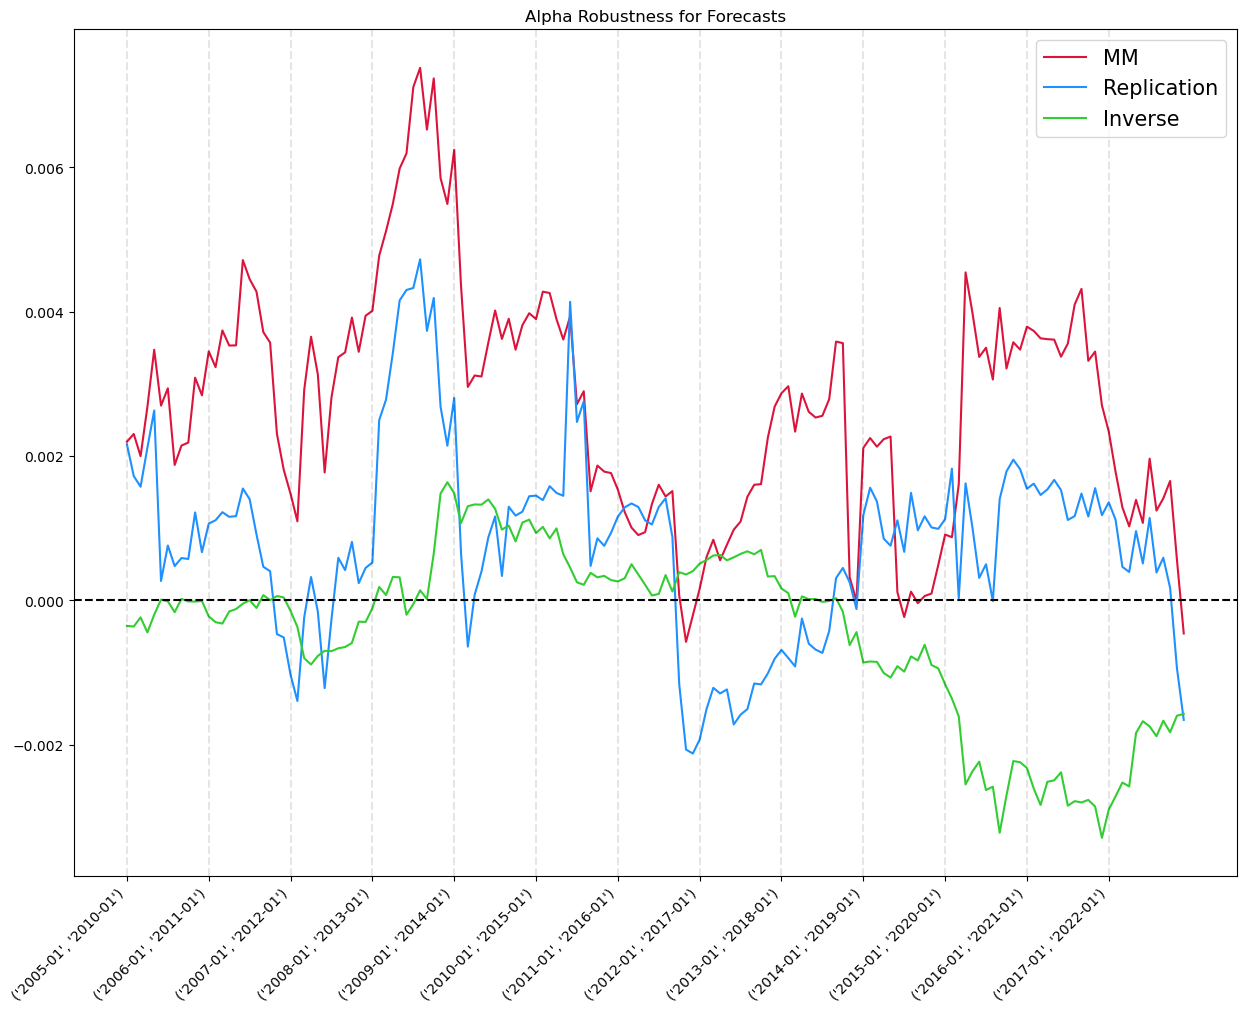

In [36]:
# Prediction portfolios rolling alphas 
alpha_pred_mm, _, dates = robust_exposure(pred_mm_portfolio, 'Mkt-RF')
alpha_pred_rep, _, _ = robust_exposure(rep_pred_portfolio, 'Mkt-RF')
alpha_pred_inv, _, _ = robust_exposure(inv_pred_portfolio, 'Mkt-RF')

# Plot rolling Alpha for Prediction portfolios
plot_mult_alpha_robust([alpha_pred_mm, alpha_pred_rep, alpha_pred_inv], dates, ['MM', 'Replication', 'Inverse'], ['crimson', 'dodgerblue', 'limegreen'], "Forecasts")

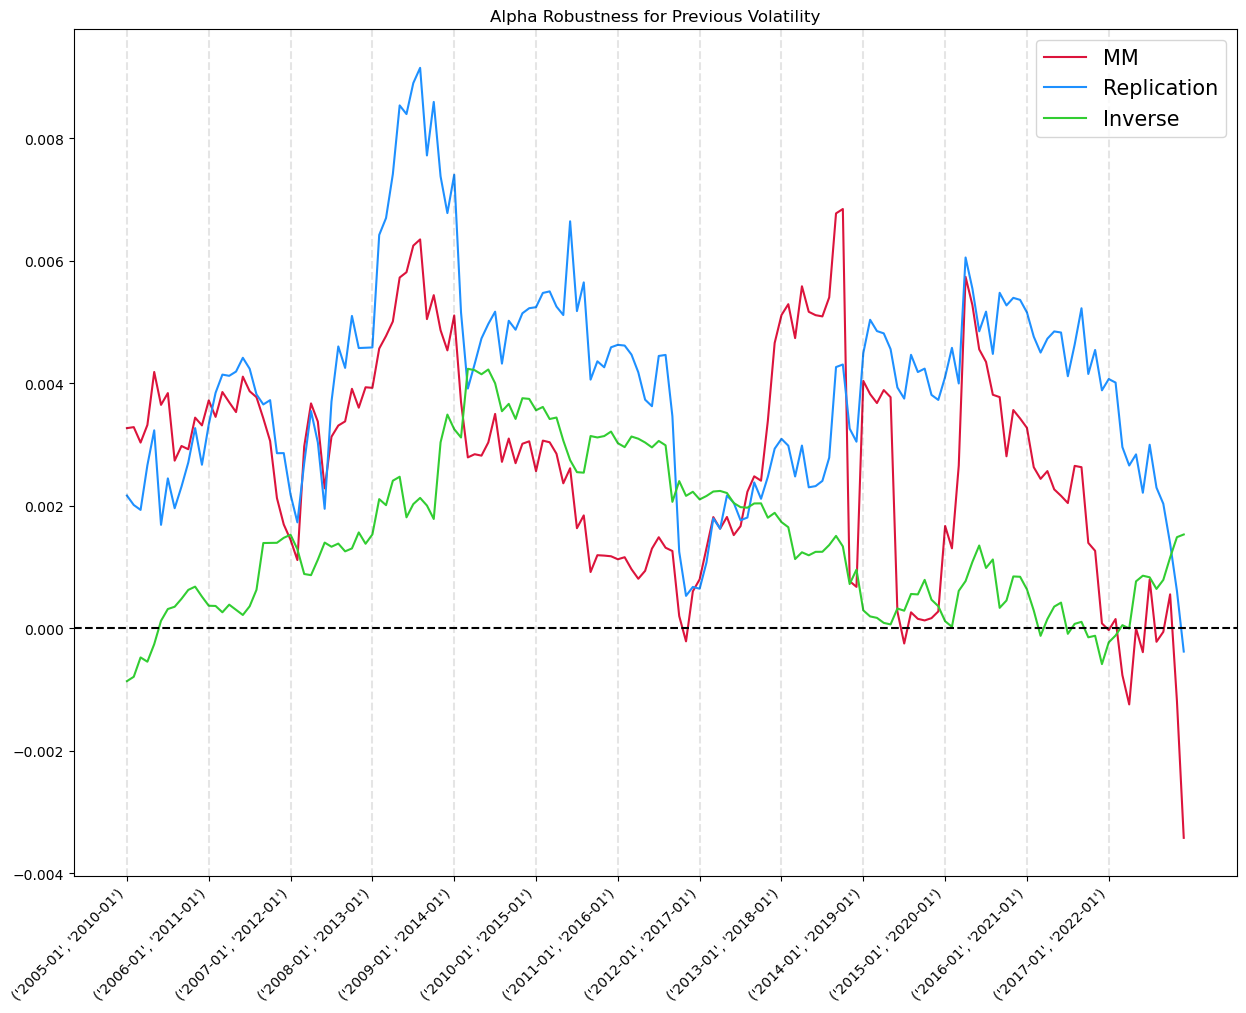

In [37]:
alpha_prev_mm, _, dates = robust_exposure(prev_mm_portfolio, 'Mkt-RF')
alpha_prev_rep, _, _ = robust_exposure(rep_prev_portfolio, 'Mkt-RF')
alpha_prev_inv, _, _ = robust_exposure(inv_prev_portfolio, 'Mkt-RF')

# Plot rolling Alpha for Previous portfolios
plot_mult_alpha_robust([alpha_prev_mm, alpha_prev_rep, alpha_prev_inv], dates, ['MM', 'Replication', 'Inverse'], ['crimson', 'dodgerblue', 'limegreen'], "Previous Volatility")

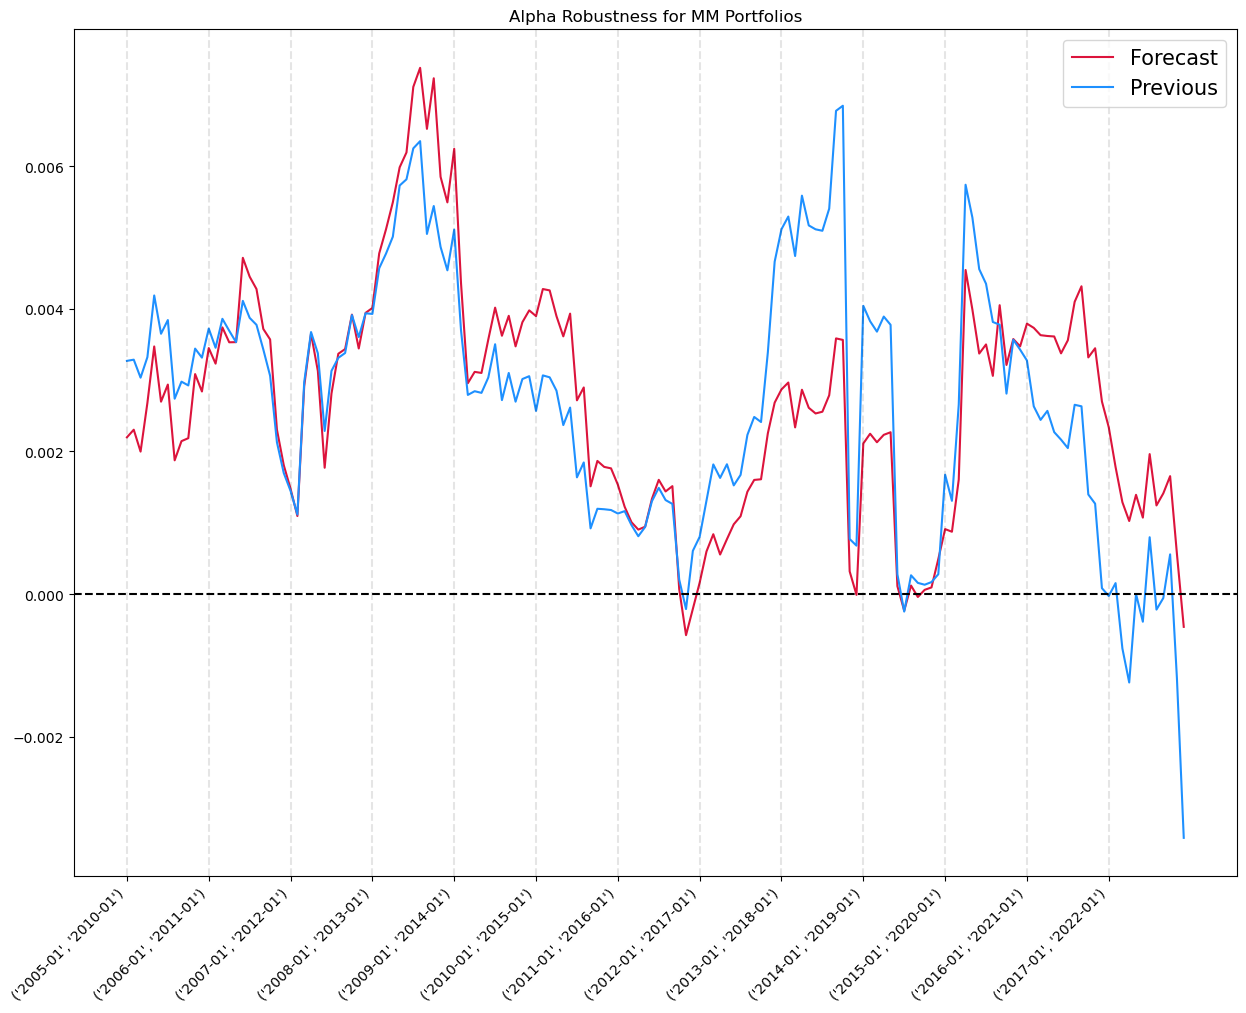

In [38]:
# Plot rolling Alpha for MM Portfolios
plot_mult_alpha_robust([alpha_pred_mm, alpha_prev_mm], dates, ['Forecast', 'Previous'], ['crimson', 'dodgerblue'], "MM Portfolios")

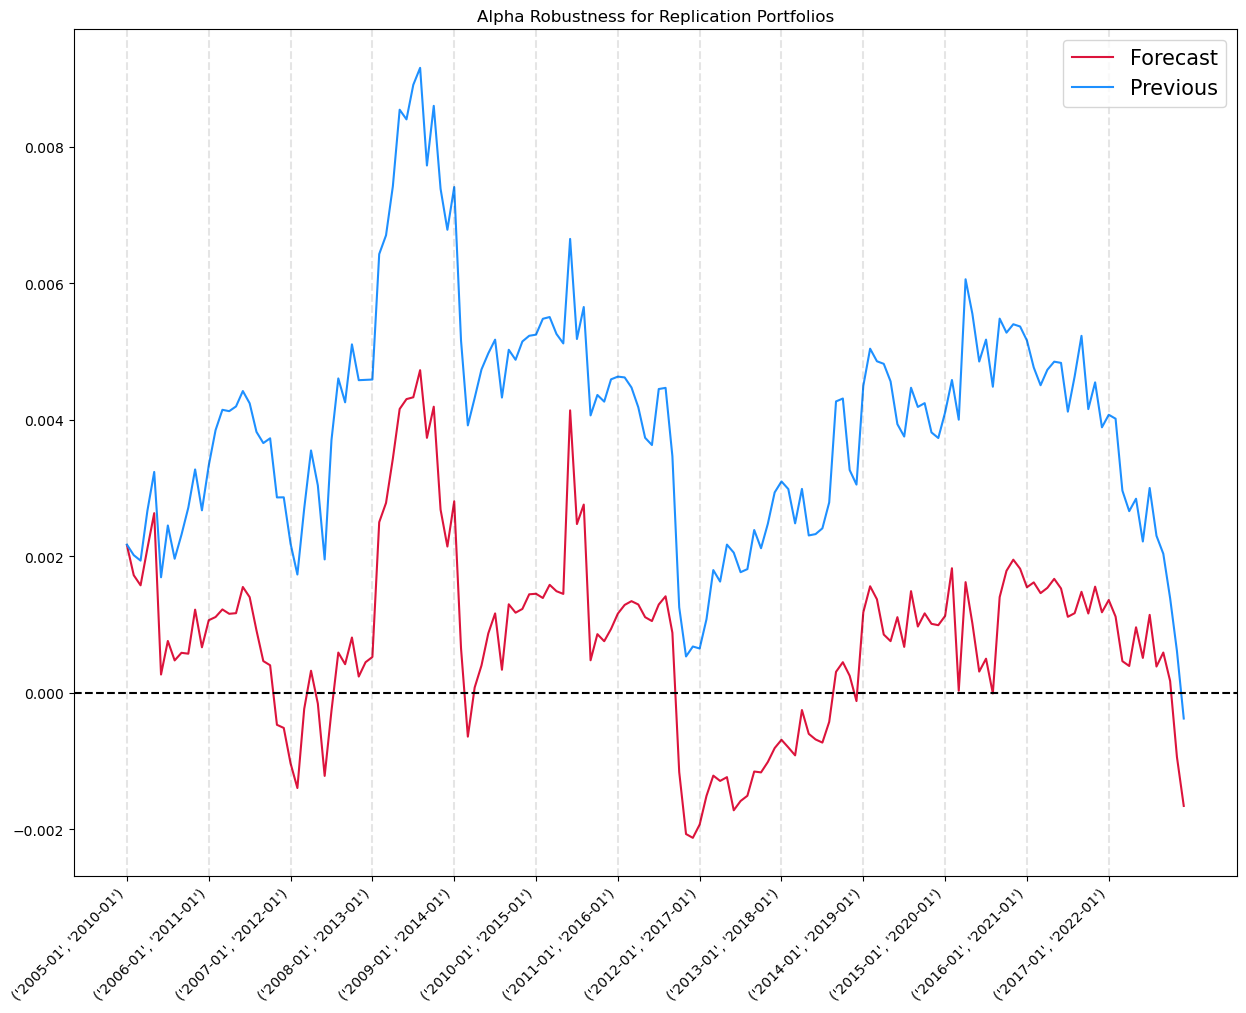

In [39]:
# Plot rolling Alpha for Replication Portfolios
plot_mult_alpha_robust([alpha_pred_rep, alpha_prev_rep], dates, ['Forecast', 'Previous'], ['crimson', 'dodgerblue'], "Replication Portfolios")

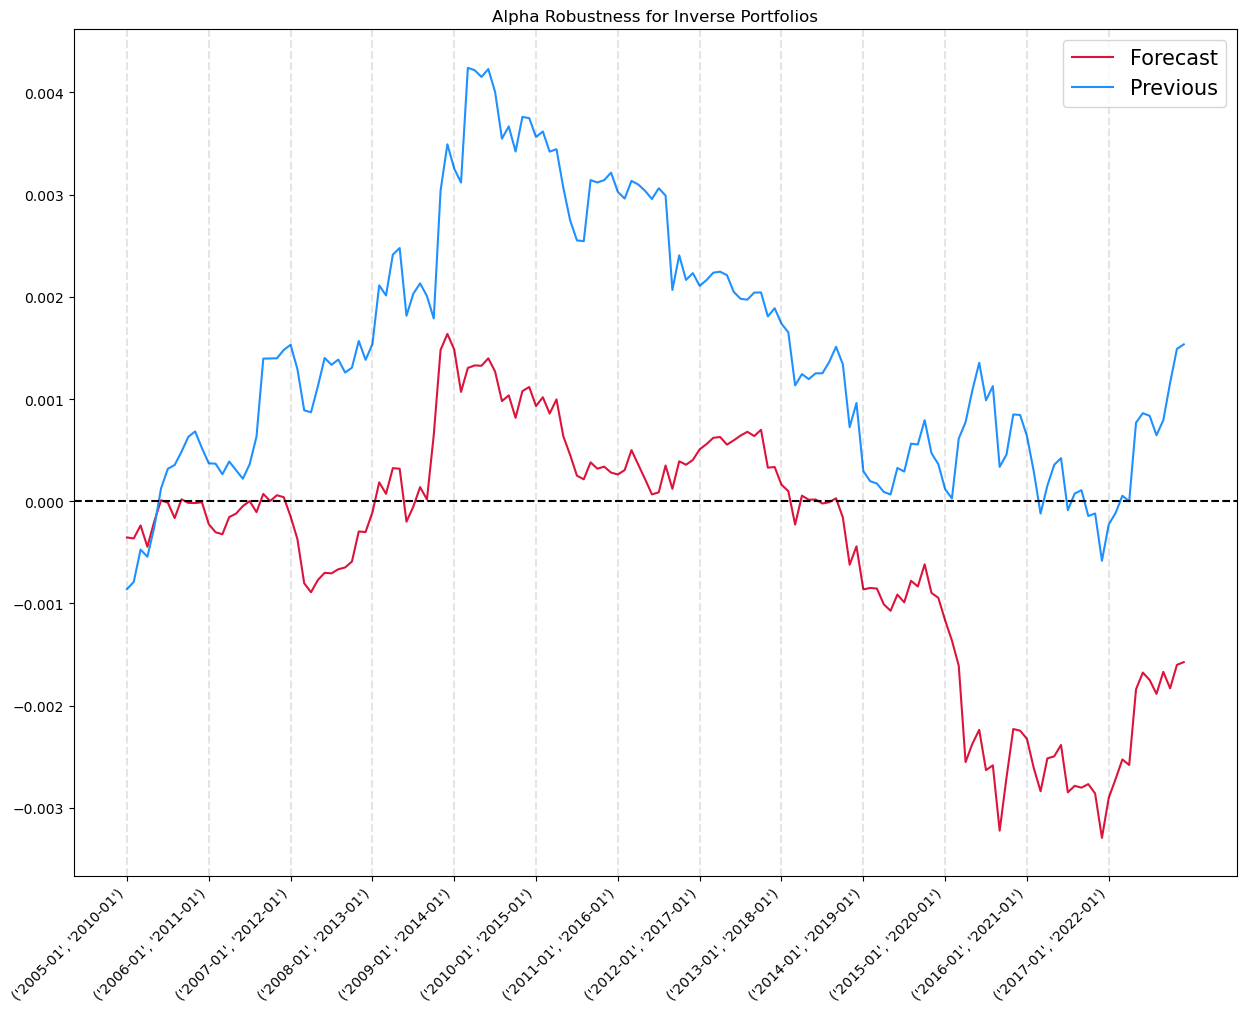

In [40]:
# Plot rolling Alpha for Inverse Portfolios
plot_mult_alpha_robust([alpha_pred_inv, alpha_prev_inv], dates, ['Forecast', 'Previous'], ['crimson', 'dodgerblue'], "Inverse Portfolios")

## **Weight Constraints**

### **Stock-Level Portfolios**

For this case, we apply minimum weight thresholds. We will consider the case for minimum weights of 0.1% of the portfolio. (Keep in mind the index has 500 stocks each month, so in an equal weighted basis the weight for each stock is 0.2%)

In [41]:
# Function to constraint minimum equity weights in portfolio
def constrain_weights_by_month(df, weights_col, min_weight=0.001):

    # Group the DataFrame by the 'datadate' column
    grouped = df.groupby('datadate')

    # Create a new DataFrame to store the constrained weights
    constrained_df = []

    # Iterate over groups (months) and apply the constraint to each
    for date, group in grouped:

        weights = group[weights_col].values
        
        # Identify stocks with weights less than min_weight
        low_weight_indices = np.where(weights < min_weight)[0]

        # Calculate the total weight that needs to be redistributed
        total_redistributed_weight = weights[low_weight_indices].sum()

        # Set weights below min_weight to zero
        weights[low_weight_indices] = 0

        # Redistribute the total redistributed weight among other stocks
        non_zero_weights = weights[weights > 0]
        non_zero_weights += total_redistributed_weight / len(non_zero_weights)

        # Update the weights in the original array
        weights[weights > 0] = non_zero_weights

        # Append the constrained weights to the list
        constrained_df.append(pd.DataFrame({'datadate': [date]*len(weights), 'constrained_weight': weights}))
    
    constrained_df = pd.concat(constrained_df, ignore_index=True)

    return constrained_df

In [42]:
# Apply weight constraints to the Inverse portfolio
inv_pred_cons = constrain_weights_by_month(test, 'w_inv_Predicted', 0.001)
inv_pred_cons_w = inv_pred_cons.constrained_weight
inv_pred_cons.constrained_weight = inv_pred_cons.constrained_weight * test.exc_ret
inv_pred_cons = inv_pred_cons.groupby('datadate').sum()
inv_pred_cons.rename({'constrained_weight':'Cons. Inv. Predicted Portfolio'}, axis=1, inplace=True)

In [43]:
# Apply weight constraints to the Replication portfolio
rep_pred_cons = constrain_weights_by_month(test, 'w_rep_Predicted', 0.001)
rep_pred_cons_w = rep_pred_cons.constrained_weight
rep_pred_cons.constrained_weight = rep_pred_cons.constrained_weight * test.exc_ret
rep_pred_cons = rep_pred_cons.groupby('datadate').sum()
rep_pred_cons.rename({'constrained_weight':'Cons. Rep. Predicted Portfolio'}, axis=1, inplace=True)

In [44]:
# Show statistics for constrained portfolios
cons_dfs = [inv_pred_cons, inv_pred_portfolio, rep_pred_cons, rep_pred_portfolio] 
merged_cons_df = reduce(lambda left, right: pd.merge(left, right, on='datadate', how='outer'), cons_dfs)
merged_cons_df.set_index('datadate', inplace=True)

calculate_statistics(merged_cons_df)

,Average Monthly Return,Monthly Returns Volatility,Annualized Return,Annualized Volatility,Sharpe Ratio,Downside Deviation,Sortino Ratio
Cons. Inv. Predicted Portfolio,0.009264,0.040436,0.111170,0.140075,0.793649,0.105436,1.054387
Inv. Predicted Portfolio,0.009559,0.041117,0.114712,0.142432,0.805382,0.107216,1.069912
Cons. Rep. Predicted Portfolio,0.010589,0.042216,0.127066,0.146242,0.868877,0.111425,1.140374
Replication Predicted Portfolio,0.010855,0.042758,0.130261,0.148119,0.879435,0.112279,1.160157


### **Limit Leverage Portfolios**

Constraints to Leverage strategies. As we are considering we are investing in an index, we will consider constraints at the portfolio level (meaning not for stock individual weights). This way, we will place 3 leverage constraints on the different portfolios, and observe their behaviour. (1 = no leverage; 1.5 = 50% leverage; 2 = 100% leverage)

In [45]:
# Function to apply leverage limits to levered portfolios
def cons_leverage_portfolios(limit, weights, rf, new_portfolio_name):

    new_weights = copy.deepcopy(weights)
    new_weights[new_weights > limit] = limit
    rets = (new_weights * vw_portfolio['VW Portfolio']) + ((1-weights) * rf)  # change the returns to general returns and apply this for also the inv mm portfolios
    dates = vw_portfolio['datadate']
    rets = pd.DataFrame(data = {'datadate':dates, new_portfolio_name:rets}).set_index("datadate")

    return rets, new_weights


In [46]:
# Leverage limit for MM Predicted Portfolio
cons1_pred_mm, cons1_w_pred_mm = cons_leverage_portfolios(1, w_pred_mm, ff_factors['RF'], "Cons. 1 Predicted MM Portfolio")
cons15_pred_mm, cons15_w_pred_mm = cons_leverage_portfolios(1.5, w_pred_mm, ff_factors['RF'], "Cons. 1.5 Predicted MM Portfolio")
cons2_pred_mm, cons2_w_pred_mm = cons_leverage_portfolios(2, w_pred_mm, ff_factors['RF'], "Cons. 2 Predicted MM Portfolio")

# Leverage limit for Replication Predicted Portfolio
cons1_pred_rep, cons1_w_pred_rep = cons_leverage_portfolios(1, w_pred_rep.reset_index(drop=True), ff_factors['RF'], "Cons. 1 Predicted Rep. Portfolio")
cons15_pred_rep, cons15_w_pred_rep = cons_leverage_portfolios(1.5, w_pred_rep.reset_index(drop=True), ff_factors['RF'], "Cons. 1.5 Predicted Rep. Portfolio")
cons2_pred_rep, cons2_w_pred_rep = cons_leverage_portfolios(2, w_pred_rep.reset_index(drop=True), ff_factors['RF'], "Cons. 2 Predicted Rep. Portfolio")

In [47]:
# Show statistics for constrained portfolios
calculate_statistics(reduce(lambda left, right: pd.merge(left, right, on='datadate', how='outer'), [cons1_pred_mm, cons15_pred_mm, cons2_pred_mm, pred_mm_portfolio.set_index('datadate'),
                                                                                                    cons1_pred_rep, cons15_pred_rep, cons2_pred_rep, rep_pred_portfolio.set_index('datadate') ]))

,Average Monthly Return,Monthly Returns Volatility,Annualized Return,Annualized Volatility,Sharpe Ratio,Downside Deviation,Sortino Ratio
Cons. 1 Predicted MM Portfolio,0.008084,0.029450,0.097008,0.102017,0.950904,0.068045,1.425643
Cons. 1.5 Predicted MM Portfolio,0.009904,0.035585,0.118844,0.123269,0.964103,0.083724,1.419473
Cons. 2 Predicted MM Portfolio,0.011148,0.039725,0.133781,0.137613,0.972152,0.096284,1.389443
Predicted MM Portfolio,0.011523,0.042758,0.138280,0.148118,0.933580,0.110666,1.249529
Cons. 1 Predicted Rep. Portfolio,0.008372,0.032098,0.100470,0.111191,0.903579,0.077616,1.294452
Cons. 1.5 Predicted Rep. Portfolio,0.010687,0.040179,0.128239,0.139185,0.921357,0.098167,1.306341
Cons. 2 Predicted Rep. Portfolio,0.011666,0.044782,0.139989,0.155128,0.902404,0.115061,1.216643
Replication Predicted Portfolio,0.010855,0.042758,0.130261,0.148119,0.879435,0.112279,1.160157


In [48]:
# Leverage limit for MM Previous Portfolio
cons1_prev_mm, cons1_w_prev_mm = cons_leverage_portfolios(1, w_prev_mm, ff_factors['RF'], "Cons. 1 Previous MM Portfolio")
cons15_prev_mm, cons15_w_prev_mm = cons_leverage_portfolios(1.5, w_prev_mm, ff_factors['RF'], "Cons. 1.5 Previous MM Portfolio")
cons2_prev_mm, cons2_w_prev_mm = cons_leverage_portfolios(2, w_prev_mm, ff_factors['RF'], "Cons. 2 Previous MM Portfolio")

# Leverage limit for Replication Previous Portfolio
cons1_prev_rep, cons1_w_prev_rep = cons_leverage_portfolios(1, w_prev_rep.reset_index(drop=True), ff_factors['RF'], "Cons. 1 Previous Rep. Portfolio")
cons15_prev_rep, cons15_w_prev_rep = cons_leverage_portfolios(1.5, w_prev_rep.reset_index(drop=True), ff_factors['RF'], "Cons. 1.5 Previous Rep. Portfolio")
cons2_prev_rep, cons2_w_prev_rep = cons_leverage_portfolios(2, w_prev_rep.reset_index(drop=True), ff_factors['RF'], "Cons. 2 Previous Rep. Portfolio")

In [49]:
# Show statistics for constrained portfolios
calculate_statistics(reduce(lambda left, right: pd.merge(left, right, on='datadate', how='outer'), [cons1_prev_mm, cons15_prev_mm, cons2_prev_mm, prev_mm_portfolio.set_index('datadate'),
                                                                                                    cons1_prev_rep, cons15_prev_rep, cons2_prev_rep, rep_prev_portfolio.set_index('datadate') ]))

,Average Monthly Return,Monthly Returns Volatility,Annualized Return,Annualized Volatility,Sharpe Ratio,Downside Deviation,Sortino Ratio
Cons. 1 Previous MM Portfolio,0.006187,0.022158,0.074240,0.076758,0.967204,0.056227,1.320356
Cons. 1.5 Previous MM Portfolio,0.007510,0.027604,0.090120,0.095622,0.942462,0.073505,1.226039
Cons. 2 Previous MM Portfolio,0.008487,0.031899,0.101843,0.110502,0.921638,0.089811,1.133967
Previous MM Portfolio,0.009592,0.042757,0.115105,0.148114,0.777135,0.137238,0.838725
Cons. 1 Previous Rep. Portfolio,0.008288,0.032909,0.099456,0.113999,0.872432,0.078065,1.274026
Cons. 1.5 Previous Rep. Portfolio,0.010650,0.041940,0.127798,0.145285,0.879634,0.102390,1.248156
Cons. 2 Previous Rep. Portfolio,0.011920,0.047908,0.143043,0.165959,0.861920,0.120785,1.184285
Replication Previous Portfolio,0.012540,0.042757,0.150484,0.148114,1.015999,0.098728,1.524229


### **Factor Benchmark Constrained Portfolio**

Benchmark the Constrained Predicted Replication Portfolio against the Market Factor.

In [50]:
cons_dfs = [cons1_pred_rep.reset_index(), cons15_pred_rep.reset_index(), rep_pred_portfolio]
market_regression_results(cons_dfs, new_factors)

R-Squared    Alpha            Mkt-RF  \
                                                 Coef  P-Value     Coef   
Index                                                                     
Cons. 1 Predicted Rep. Portfolio     0.81382  0.00117  0.22929  0.67726   
Cons. 1.5 Predicted Rep. Portfolio    0.7338  0.00213  0.14529  0.80502   
Replication Predicted Portfolio      0.63378  0.00239  0.18978  0.79617   

                                            Information Ratio  
                                    P-Value                    
Index                                                          
Cons. 1 Predicted Rep. Portfolio    0.00000           0.29354  
Cons. 1.5 Predicted Rep. Portfolio  0.00000           0.35589  
Replication Predicted Portfolio     0.00000           0.32027